# 2nd Method — KNN

In [12]:
%pip install --upgrade mido numpy pandas matplotlib enlighten scikit-learn seaborn

import mido
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import enlighten
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pathlib import Path

# Load metadata
df = pd.read_csv("maestro-v3.0.0/maestro-v3.0.0.csv")

# Add metadata column for absolute file paths
df["midi_path"] = df["midi_filename"].apply(
    lambda p: Path("maestro-v3.0.0") / p
)

# Split data; validation data possibly unnecessary
df_train = df[df["split"].isin(["train", "validation"])].head(50) # 962 + 137 elements
df_test  = df[df["split"] == "test"].head(10) # 177 elements

FPS = 20 # MIDI sampling/interpolation rate
ACTIVE_THRESHOLD = 64 # Threshold at which pedal is considered on
INTERVAL_DISSONANCE = { # Lookup for dissonance based on interval dissonance
    0: 0,   1: 4,  2: 4,
    3: 2,   4: 2,  5: 3,
    6: 5,   7: 1,
    8: 2,   9: 2,
    10: 4, 11: 4,
    12: 0
}
WINDOW_SIZE = 20 # Number of samples to make features

Note: you may need to restart the kernel to use updated packages.


In [13]:
def interval_dissonance(n1, n2):
    interval = abs(n1 - n2) % 12
    return INTERVAL_DISSONANCE.get(interval, 0)

#####--------------------#####

def current_dissonance(notes):
    """Sum dissonances for all unique unordered pairs of notes."""
    if len(notes) < 2:
        return 0
    notes = list(notes)
    d = 0
    for i in range(len(notes)):
        for j in range(i + 1, len(notes)):
            d += interval_dissonance(notes[i], notes[j])
    return d

#####--------------------#####

def extract_pedal(midi):
    curve = []
    time_s = 0

    for msg in midi:
        time_s += msg.time
        # control=64 indicates sustain pedal
        if msg.type == "control_change" and msg.control == 64:
            # Append current time and pedal value
            curve.append((time_s, msg.value))
    return curve

#####--------------------#####

def pedal_to_binary(values, active_threshold=ACTIVE_THRESHOLD):
    values = np.asarray(values)
    return (values > active_threshold).astype(int)

#####--------------------#####

def resample_curve(times, values, fps=FPS):
    """
    Given irregular event times/values (like pedal or dissonance),
    resample to a regular FPS grid using forward-fill interpolation.
    """
    times = np.asarray(times)
    values = np.asarray(values)

    t_end = times[-1]
    t_grid = np.arange(0, t_end, 1.0 / fps)

    # For each grid time, find the last event time <= t
    idx = np.searchsorted(times, t_grid, side="right") - 1
    idx[idx < 0] = 0

    return t_grid, values[idx]

#####--------------------#####

def compute_dissonance_no_pedal(midi):
    """
    Computes instantaneous harmonic dissonance across the entire MIDI,
    completely ignoring pedal usage.

    finger_held = notes currently pressed by fingers

    Dissonance at each event = sum of interval dissonances among all held notes.
    """
    times = []
    diss_curve = []

    current_time = 0

    finger_held = set()

    for msg in midi:
        current_time += msg.time

        # --- NOTE ON ---
        if msg.type == "note_on" and msg.velocity > 0:
            finger_held.add(msg.note)

        # --- NOTE OFF ---
        if msg.type == "note_off" or (msg.type == "note_on" and msg.velocity == 0):
            if msg.note in finger_held:
                finger_held.remove(msg.note)

        # --- Compute instantaneous dissonance ---
        diss = current_dissonance(finger_held)

        times.append(current_time)
        diss_curve.append(diss)

    return np.array(times), np.array(diss_curve)

#####--------------------#####

def predict_pedal_knn(midi_path, model, window_size=WINDOW_SIZE):
    """
    Returns: time grid and pedal state predictions
    """
    midi = mido.MidiFile(midi_path)
    d_times, d_vals = compute_dissonance_no_pedal(midi)
    t_grid, diss_res = resample_curve(d_times, d_vals)

    if len(diss_res) < window_size:
        return t_grid, np.ones_like(diss_res)

    X_pred = np.column_stack([diss_res[i: i + len(diss_res) - window_size + 1] for i in range(window_size)])
    y_pred = model.predict(X_pred)

    # Pad the first window_size-1 frames with pedal down (1)
    y_pred_full = np.concatenate([np.ones(window_size-1, dtype=int), y_pred])

    return t_grid, y_pred_full

#####--------------------#####

def evaluate_knn(df_test, knn_model):
    y_true_all = []
    y_pred_all = []

    for _, row in df_test.iterrows():
        midi_path = row["midi_path"]
        original_pedal = extract_pedal(mido.MidiFile(midi_path))
        ped_times, ped_vals = zip(*original_pedal)
        ped_binary = pedal_to_binary(np.array(ped_vals))
        t_grid_true, p_true = resample_curve(ped_times, ped_binary)

        # Predicted pedal
        t_grid_pred, p_pred = predict_pedal_knn(midi_path, knn_model)

        # Make sure lengths match
        min_len = min(len(p_true), len(p_pred))
        y_true_all.extend(p_true[:min_len])
        y_pred_all.extend(p_pred[:min_len])

    cm = confusion_matrix(y_true_all, y_pred_all)
    return cm

In [14]:
# --- 1. Prepare Training Data for KNN ---
X_train_data = []
y_train_data = []

features_release = []  # Class 0
features_hold = []     # Class 1

manager = enlighten.get_manager()
pbar = manager.counter(total=len(df_train), desc='Processing MIDI files', unit='file')

for _, row in df_train.iterrows():
    midi = mido.MidiFile(row["midi_path"])
    sustain_curve = extract_pedal(midi)
    if not sustain_curve:
        continue

    p_times, p_vals = zip(*sustain_curve)
    p_binary = pedal_to_binary(p_vals)
    d_times, d_vals = compute_dissonance_no_pedal(midi)

    t_grid, ped_res = resample_curve(p_times, p_binary)
    _, diss_res = resample_curve(d_times, d_vals)

    min_len = min(len(ped_res), len(diss_res))
    ped_res = ped_res[:min_len]
    diss_res = diss_res[:min_len]

    # Create sliding window features
    if min_len < WINDOW_SIZE:
        continue  # skip very short sequences

    X = np.column_stack([diss_res[i: i + min_len - WINDOW_SIZE + 1] for i in range(WINDOW_SIZE)])
    y = ped_res[WINDOW_SIZE - 1:]

    features_release.append(X[y == 0])
    features_hold.append(X[y == 1])

    pbar.update()

manager.stop()

# Total number of release samples
n_release = sum(len(f) for f in features_release)

# Total number of hold samples
n_hold = sum(len(f) for f in features_hold)

print(f"Number of release samples: {n_release}")
print(f"Number of hold samples: {n_hold}")
print(f"Release/Hold ratio: {n_release / n_hold:.3f}")

Number of release samples: 95139
Number of hold samples: 455596
Release/Hold ratio: 0.209


In [15]:
# --- 2. Train KNN ---
knn = None

if features_release and features_hold:
    X_final = np.vstack(features_release + features_hold)
    y_final = np.hstack([np.zeros(len(np.vstack(features_release))),
                         np.ones(len(np.vstack(features_hold)))])

    print(f"Training KNN on {len(y_final)} samples...")
    knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
    knn.fit(X_final, y_final)
    print("KNN Training Complete.")
else:
    print("Insufficient data found to train KNN. Check MIDI paths or pedal events.")

Training KNN on 550735 samples...
KNN Training Complete.


## Sampling

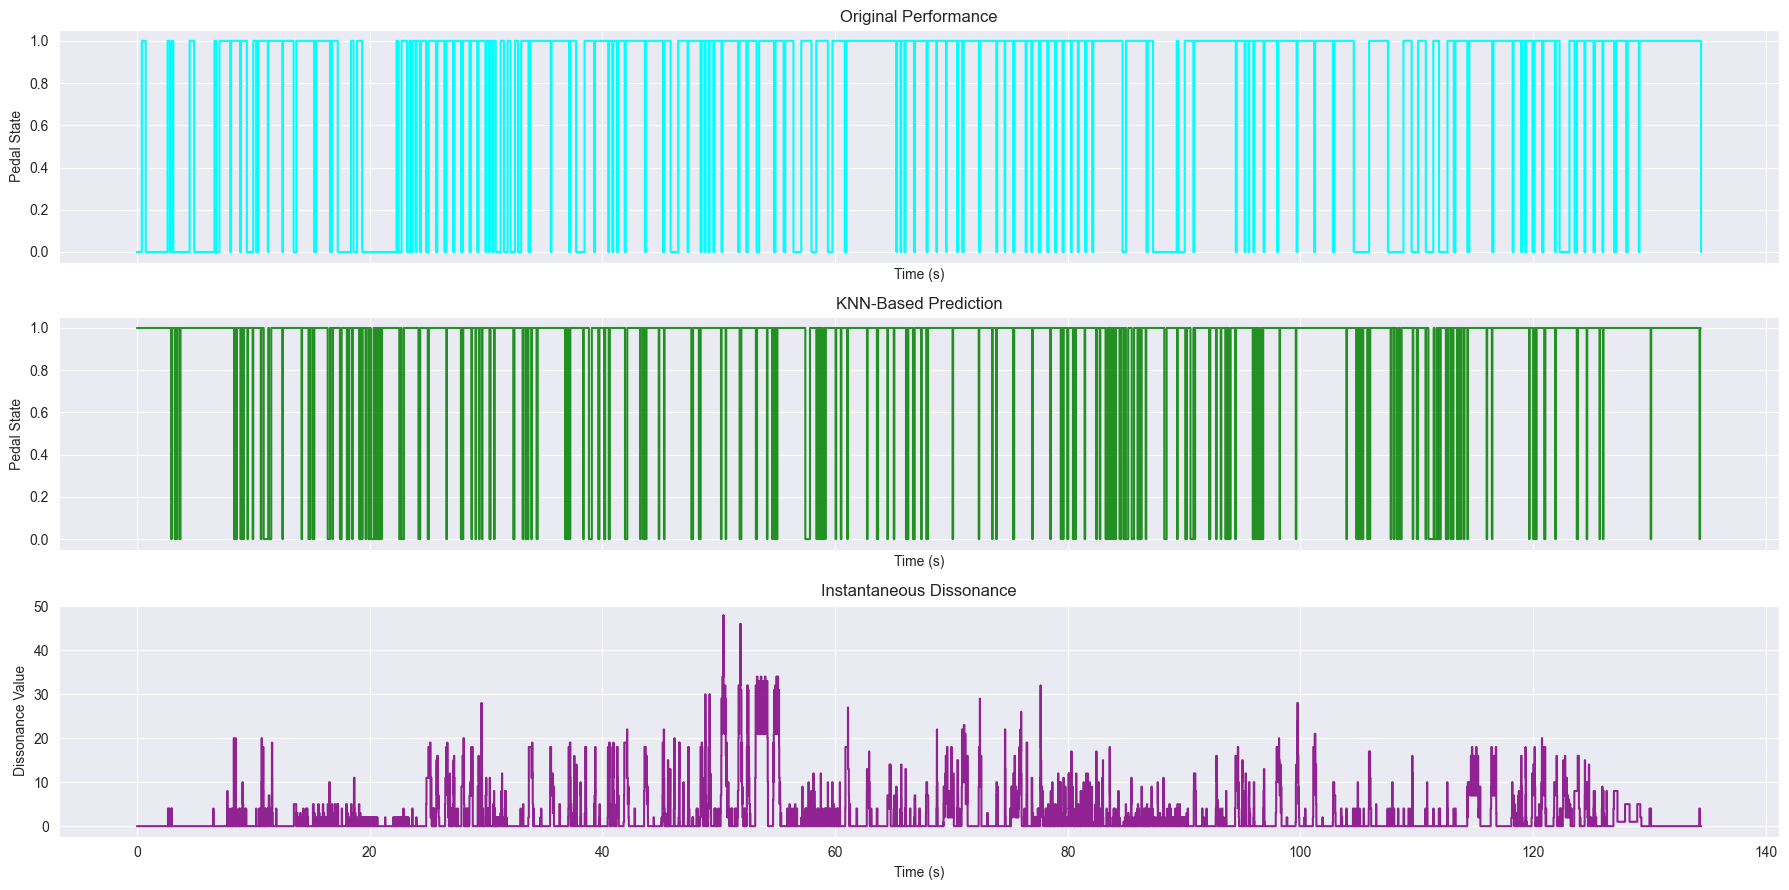

In [16]:
if knn is not None:
    sample = df_test.iloc[8]["midi_path"]

    # Get KNN prediction
    t_grid, ped_knn = predict_pedal_knn(sample, knn)

    # Get original curves for comparison
    midi_test = mido.MidiFile(sample)

    # Extract original curve

    p_times_orig, p_vals_orig = zip(*extract_pedal(midi_test))
    p_bin_orig = pedal_to_binary(p_vals_orig)

    d_times_orig, d_vals_orig = compute_dissonance_no_pedal(midi_test)

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

    if len(p_times_orig) > 0:
        axs[0].step(p_times_orig, p_bin_orig, where='post', color='cyan')
    axs[0].set_ylabel("Pedal State")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_title("Original Performance")

    if len(t_grid) > 0:
        axs[1].step(t_grid, ped_knn, where='post', color='green', alpha=0.85)
    axs[1].set_ylabel("Pedal State")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_title("KNN-Based Prediction")

    axs[2].step(d_times_orig, d_vals_orig, where='post', color='purple', alpha=0.85)
    axs[2].set_ylabel("Dissonance Value")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_title("Instantaneous Dissonance")

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization because KNN model failed to train.")

## Evaluation

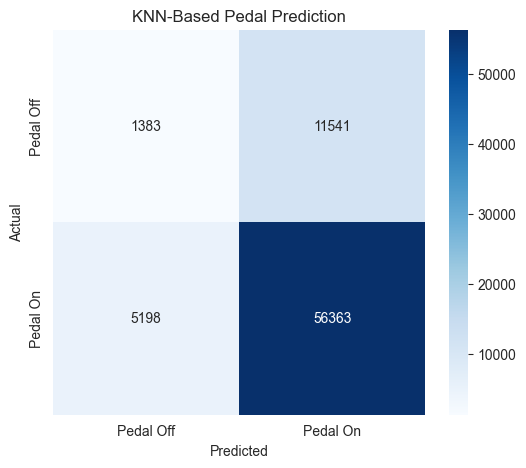

In [17]:
if knn is not None:
    cm = evaluate_knn(df_test, knn)
    class_labels=["Pedal Off", "Pedal On"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("KNN-Based Pedal Prediction")
    plt.show()
else:
    print("Skipping evaluation because KNN model failed to train.")